# Monocular Vision Based Localization Code for Dr Robot Jaguar

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

play('/kaggle/input/video-of-run/WhatsApp Video 2023-04-01 at 11.49.41.mp4')

#

In [ ]:
import cv2
import numpy as np
import os
new_flow=[]
import tensorflow as tf
path ="/kaggle/input/4-4-2023"
list_dir=os.listdir(path)
list_dir.sort()
X_train = []
frame_list=[]
frame1=cv2.imread(path + '/' + str(list_dir[0]))
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
#optical_flow = cv2.DISOpticalFlow_create()
for j in range(1,280):
    i=j
    string=path + '/' + str(list_dir[i])
    frame2=cv2.imread(string)
    frame_list.append(frame2)
    nxt = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 3, 3, 3, 5, 1.2, 0)
    X_train.append(flow)
    #plotter(frame2,flow,j)
    prvs = nxt
    prev_flow=flow

In [ ]:
import matplotlib.pyplot as plt
def plot_images(images,flows, num_rows, num_cols, figsize=(12, 8)):
    """
    Plots a list of images in a grid of subplots with a specified number of rows and columns.
    """
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Flatten the array of subplots into a 1D array
    axs = axs.ravel()

    # Iterate over the list of images and display each one in a separate subplot
    for i, frame in enumerate(images):
        # Display the image in the i-th subplot
        flow=flows[i]
        step = 16
        h, w = frame.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)

    # Extract the flow vectors at the grid points
        fx, fy = flow[y,x].T

    # Draw arrows on the frame1 image
        lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)
        for (x1, y1), (x2, y2) in lines:
            cv2.arrowedLine(frame, (x1, y1), (x2, y2), (255, 0, 10), 1, tipLength=0.2)

        axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[i].set_title('Image {}'.format(i+1))
        axs[i].axis('off')

    plt.show()

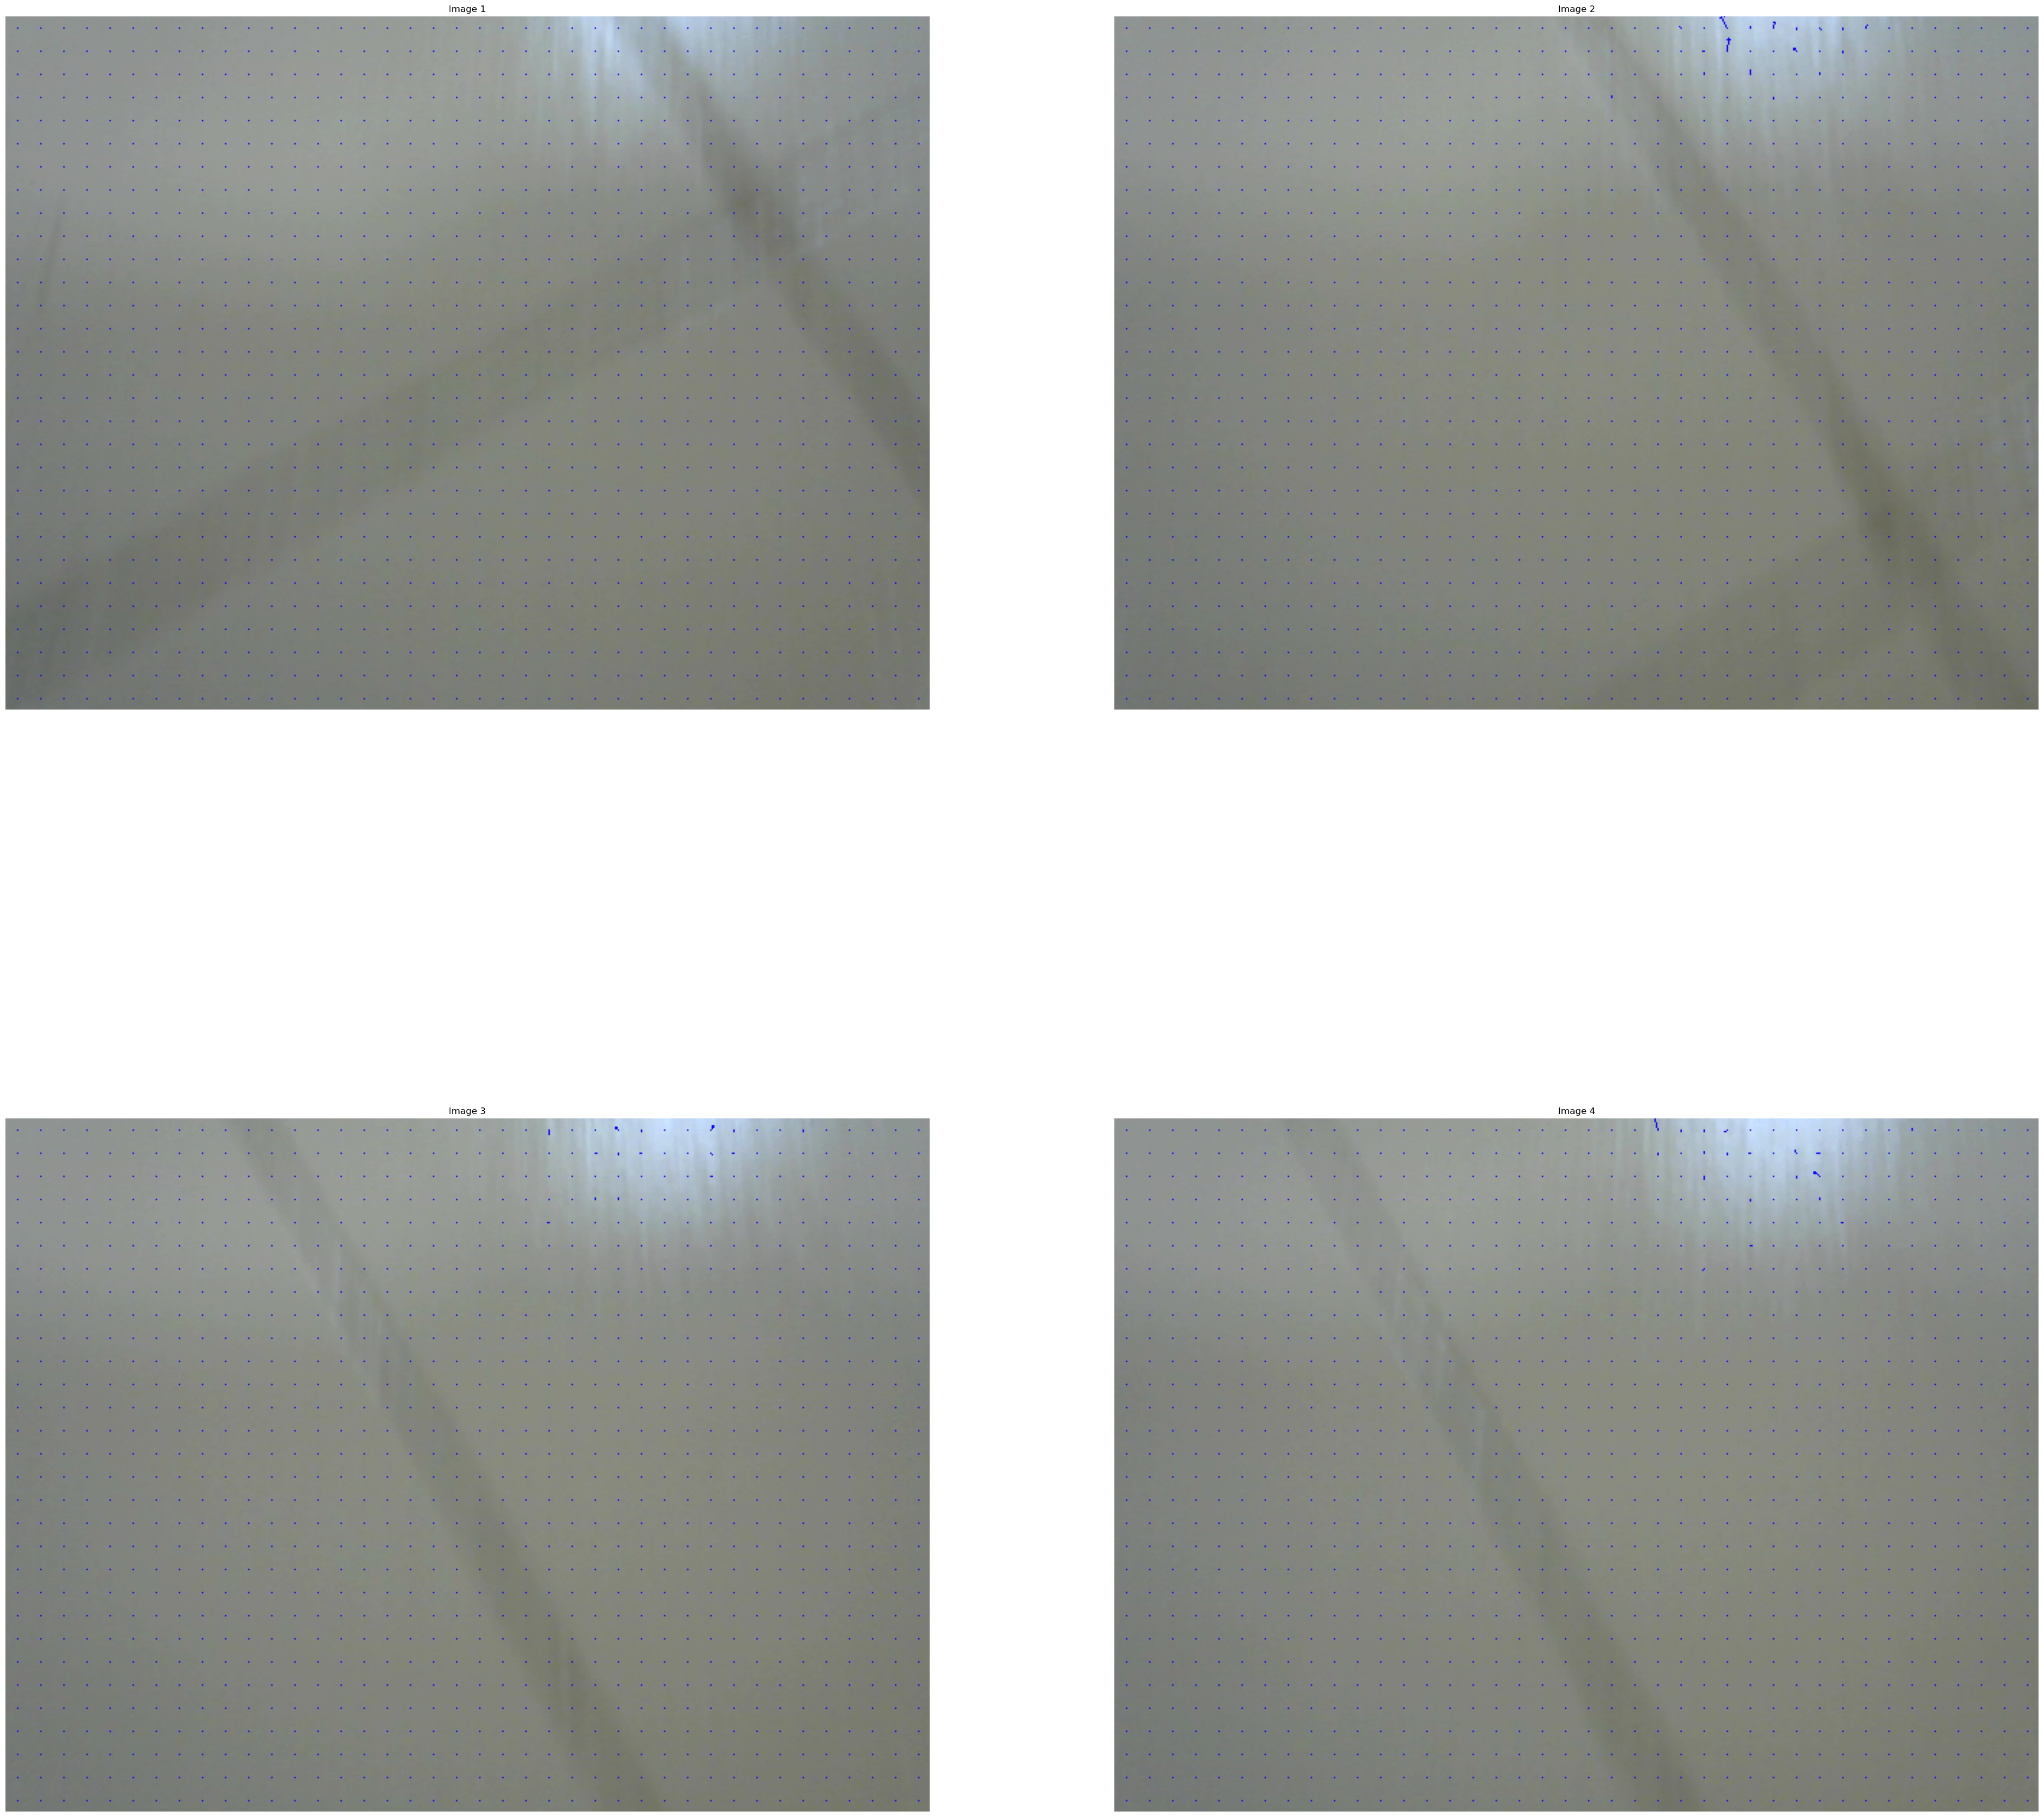

In [ ]:
plot_images(frame_list[130:134],X_train[130:134],2,2,figsize=(48,48))

In [ ]:
X_train=np.array(X_train)

In [ ]:
X_train.shape

(279, 480, 640, 2)

In [ ]:
np.save('/kaggle/working/X_train', X_train)
print("Saved Successfully")

Saved Successfully


In [ ]:
#import numpy as np
#f_arr = np.load('/kaggle/working/X_train.npy')


# Method 1 of data preprocessing of Encoders

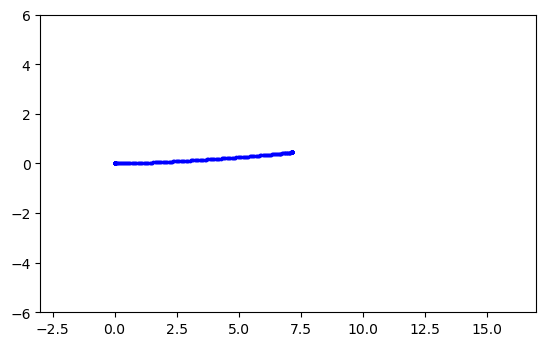

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pandas as pd
def plotting():
    line=[0,0]

    df2= pd.read_csv('/kaggle/input/04-04-2023-encoders/dr_robot_encoders.csv')
    count=0
    t_o=0
    theta_res = np.array([0, 0]).reshape(2, 1)
    theta_res_o= np.array([0, 0]).reshape(2, 1)
    theta_res_dot= np.array([0, 0]).reshape(2, 1)
    x_res = np.array([[0], [0], [0]])
    x_res_o = np.array([[0], [0], [0]])
    x = np.array([[], [], []])
    v_pk = 0
    psi_o = 0
    psi_n = 0
    en=150
    r=0.135
    w=0.52
    x = np.array([[], [], []])
    t_c=time.time()
    psi_n_1=0
    df1 = pd.DataFrame(columns=['t', 'x', 'y'])
    for k in range(0,df2.shape[0]):
        i=k
        t=l_enco=df2.loc[i,'t']
        l_enco=df2.loc[i,'left_enco']# to emulate encoder updating
        r_enco=df2.loc[i,'right_enco']
        theta_res = np.array([l_enco*2*math.pi/en, r_enco*2*math.pi/en]).reshape(2, 1)
        theta_res_dot=(theta_res-theta_res_o)/(t-t_o)
        psi_n = (theta_res[0, 0]-theta_res[1, 0])*r/w

        j_psi = np.array([[(r/2)*math.cos(psi_n), (r/2)*math.cos(psi_n)],
                     [(r/2)*math.sin(psi_n), (r/2)*math.sin(psi_n)],
                     [r/w, -r/w]])
        x_res_dot = np.dot(j_psi, theta_res_dot)


        x_0=x_res[0,0]
        y_0=x_res[1,0]

        x_res= np.array([x_res[0, 0]+x_res_dot[0,0]*(t-t_o),
                       x_res[1, 0]+x_res_dot[1,0]*(t-t_o), psi_n]).reshape(3, 1)
        x_1=x_res[0,0]
        y_1=x_res[1,0]
        df_to_append = pd.DataFrame({'dt': [t], 'dx': [(x_1-x_0)], 'dy': [(y_1-y_0)],'dpsi':psi_n-psi_n_1})
        df1 = pd.concat([df1, df_to_append], ignore_index=True)
        t_o=t
        psi_o = psi_n
        theta_res_o=theta_res
        x = np.append(x, x_res, axis=1)
        psi_n_1=psi_n


    df1.to_csv('velocities.csv', index=False)

    plt.scatter(x[0, :], x[1, :], s=3, color='b', label='encoder')
    # set the aspect ratio to be equal
    plt.gca().set_aspect('equal')
    plt.xlim((-3,17))
    plt.ylim((-6,6))
    # display the plot
    plt.show()

plotting()

 Read the y values from pandas Dataframe

In [ ]:
df= pd.read_csv('/kaggle/working/velocities.csv')
dx=df.loc[:,'dx']
dy=df.loc[:,'dy']
dpsi=df.loc[:,'dpsi']

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define the input layer for the image input
input_image = Input(shape=(480, 640, 2))

# Define the convolutional layers
conv1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_image)
conv2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2)

# Define the fully connected layers
flatten_layer = Flatten()(pool1)
dense1 = Dense(128, activation='relu')(flatten_layer)
dense2 = Dense(64, activation='relu')(dense1)

# Define the output layers for the three numerical outputs
output1 = Dense(1, name='output1')(dense2)
output2 = Dense(1, name='output2')(dense2)
output3 = Dense(1, name='output3')(dense2)

# Define the model with the input and output layers
model1 = Model(inputs=input_image, outputs=[output1, output2, output3])


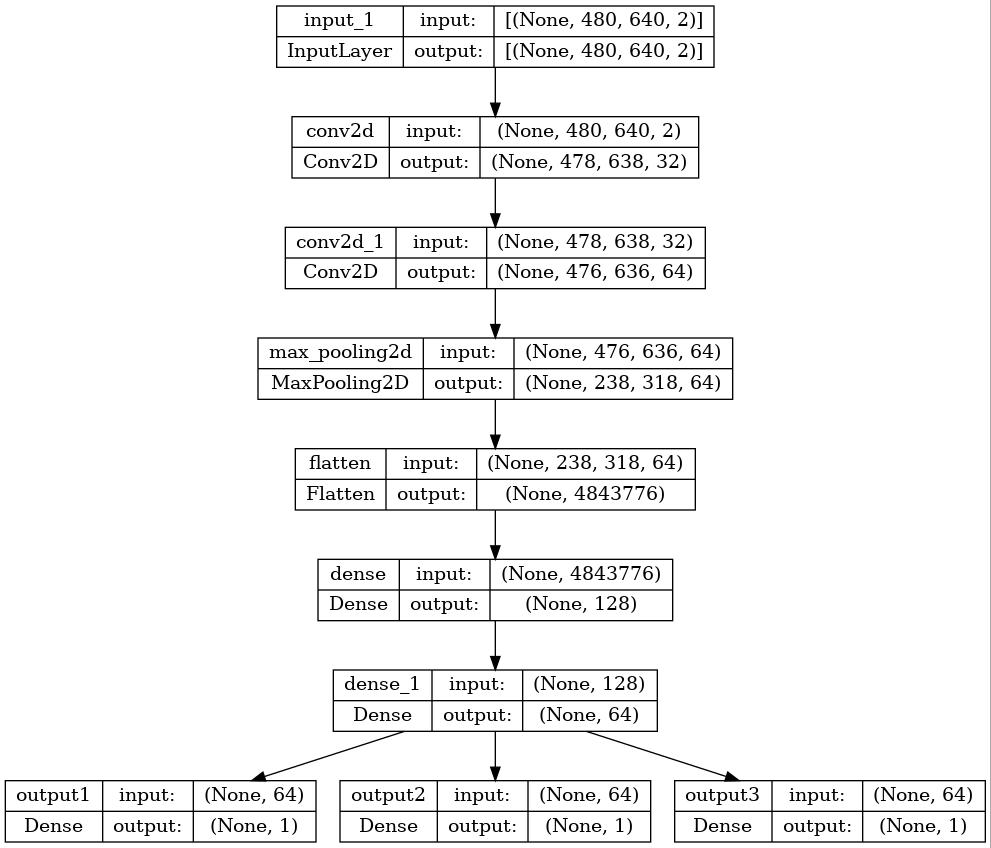

In [ ]:
ifile = 'model.jpg'
tf.keras.utils.plot_model (model1, to_file = ifile, show_shapes = True, show_layer_names = True)

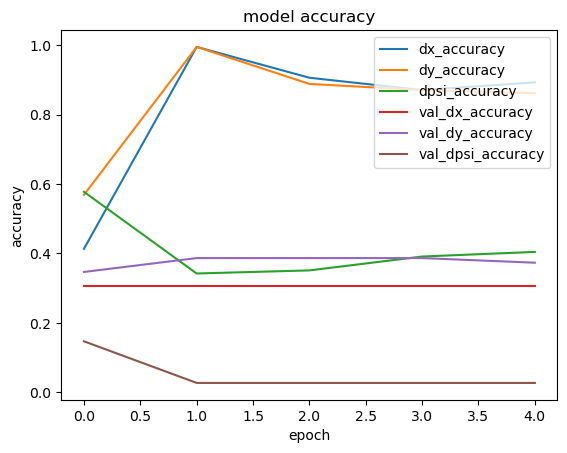

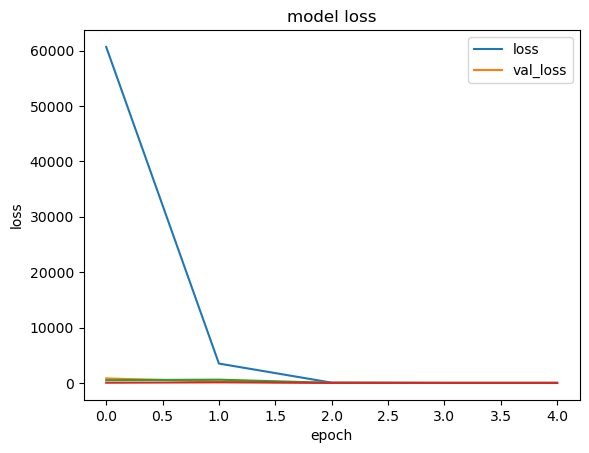

In [ ]:
plt.plot(history_1.history['output1_accuracy'])
plt.plot(history_1.history['output2_accuracy'])
plt.plot(history_1.history['output3_accuracy'])
plt.plot(history_1.history['val_output1_accuracy'])
plt.plot(history_1.history['val_output2_accuracy'])
plt.plot(history_1.history['val_output3_accuracy'])
plt.xlabel('epoch')
plt.legend(['dx_accuracy','dy_accuracy','dpsi_accuracy', 'val_dx_accuracy','val_dy_accuracy','val_dpsi_accuracy'], loc='upper right')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.show()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_output1_loss'])
plt.plot(history_1.history['val_output2_loss'])
plt.plot(history_1.history['val_output3_loss'])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.show()


 # Convolutional Neural Network Architectures of Method II

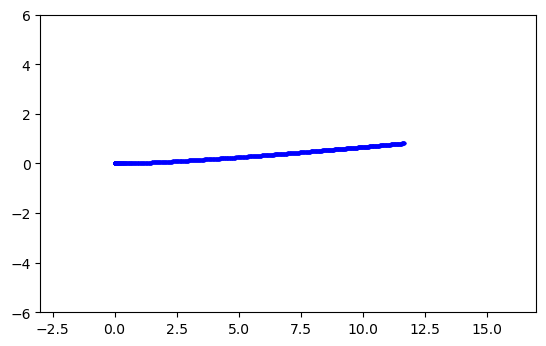

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pandas as pd
def plotting():
    line=[0,0]

    df2= pd.read_csv('/kaggle/input/rough-surfaces-enco/dr_robot_encoders.csv')
    count=0
    t_o=0
    theta_res = np.array([0, 0]).reshape(2, 1)
    theta_res_o= np.array([0, 0]).reshape(2, 1)
    theta_res_dot= np.array([0, 0]).reshape(2, 1)
    x_res = np.array([[0], [0], [0]])
    x_res_o = np.array([[0], [0], [0]])
    x = np.array([[], [], []])
    v_pk = 0
    psi_o = 0
    psi_n = 0
    en=150
    r=0.135
    w=0.52
    x = np.array([[], [], []])
    t_c=time.time()
    psi_n_1=0
    df1 = pd.DataFrame(columns=['t', 'x', 'y'])
    for i in range(df2.shape[0]):
        t=l_enco=df2.loc[i,'t']
        l_enco=df2.loc[i,'left_enco']# to emulate encoder updating
        r_enco=df2.loc[i,'right_enco']
        theta_res = np.array([l_enco*2*math.pi/en, r_enco*2*math.pi/en]).reshape(2, 1)
        theta_res_dot=(theta_res-theta_res_o)/(t-t_o)
        psi_n = (theta_res[0, 0]-theta_res[1, 0])*r/w

        j_psi = np.array([[(r/2)*math.cos(psi_n), (r/2)*math.cos(psi_n)],
                     [(r/2)*math.sin(psi_n), (r/2)*math.sin(psi_n)],
                     [r/w, -r/w]])
        x_res_dot = np.dot(j_psi, theta_res_dot)


        x_0=x_res[0,0]
        y_0=x_res[1,0]

        x_res= np.array([x_res[0, 0]+x_res_dot[0,0]*(t-t_o),
                       x_res[1, 0]+x_res_dot[1,0]*(t-t_o), psi_n]).reshape(3, 1)
        x_1=x_res[0,0]
        y_1=x_res[1,0]
        df_to_append = pd.DataFrame({'dt': [t], 'dxr': [(x_1-x_0)*math.cos(psi_n-psi_n_1)-(y_1-y_0)*math.sin(psi_n-psi_n_1)], 'dyr': [(x_1-x_0)*math.sin(psi_n-psi_n_1)+(y_1-y_0)*math.cos(psi_n-psi_n_1)],'dpsi':psi_n-psi_n_1})
        df1 = pd.concat([df1, df_to_append], ignore_index=True)
        t_o=t
        psi_o = psi_n
        theta_res_o=theta_res
        x = np.append(x, x_res, axis=1)
        psi_n_1=psi_n


    df1.to_csv('velocities_rel.csv', index=False)

    plt.scatter(x[0, :], x[1, :], s=3, color='b', label='encoder')
    # set the aspect ratio to be equal
    plt.gca().set_aspect('equal')
    plt.xlim((-3,17))
    plt.ylim((-6,6))
    # display the plot
    plt.show()

plotting()

In [ ]:
df= pd.read_csv('/kaggle/working/velocities_rel.csv')
dxr=df.loc[:,'dxr']
dyr=df.loc[:,'dyr']

# Architecture I

In [ ]:
inputs = tf.keras.Input(shape=(480,640,2))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',strides=(5,5))(inputs)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu',strides=(3,3))(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(6, 6), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)



In [ ]:
model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

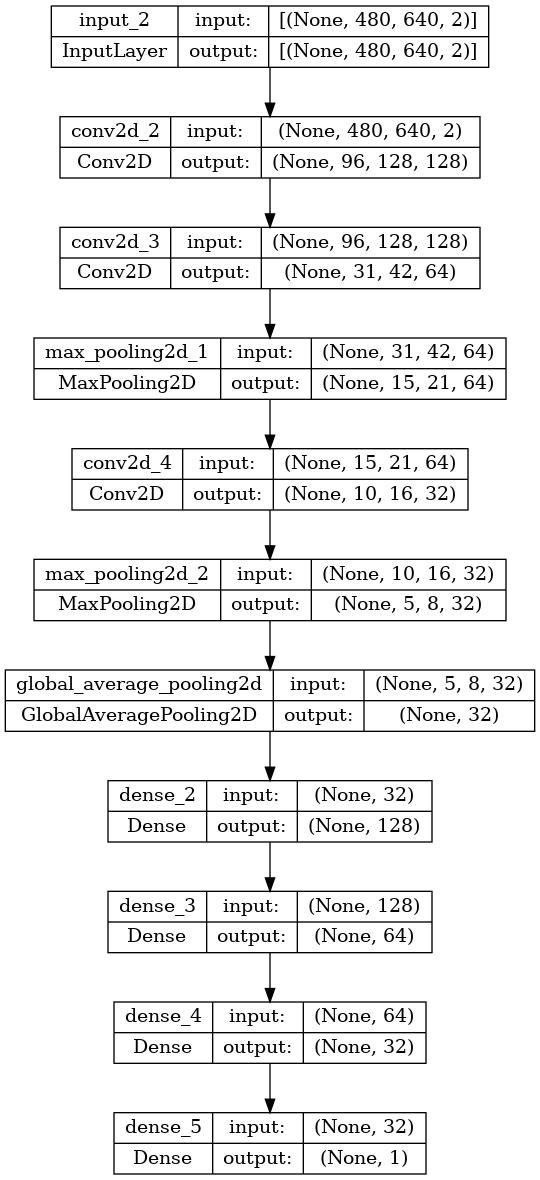

In [ ]:
ifile = 'model2.jpg'
tf.keras.utils.plot_model (model2, to_file = ifile, show_shapes = True, show_layer_names = True)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='mse',metrics=['accuracy']
)
history_2 = model.fit(X_train[:300,:,:,], dxr[:300], batch_size=50, validation_split=0.3, epochs=10,shuffle=False)

Epoch 1/10
5/5 [==============================] - 9s 1s/step - loss: 0.0628 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.4111
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 0.0205 - accuracy: 0.9714 - val_loss: 0.0029 - val_accuracy: 0.4111
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.4111
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 8.4107e-04 - val_accuracy: 0.4111
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.4111
Epoch 6/10
5/5 [==============================] - 7s 2s/step - loss: 5.0434e-04 - accuracy: 1.0000 - val_loss: 1.1004e-04 - val_accuracy: 0.4111
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 9.7616e-04 - accuracy: 1.0000 - val_loss: 5.8326e-04 - val_accuracy: 0.4111
Epoch 8/10
5/5 [=====

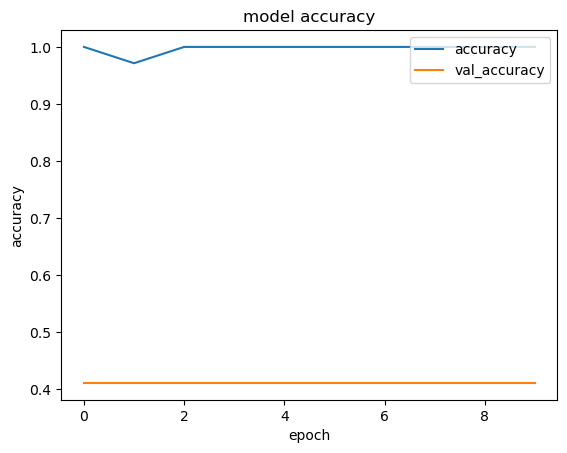

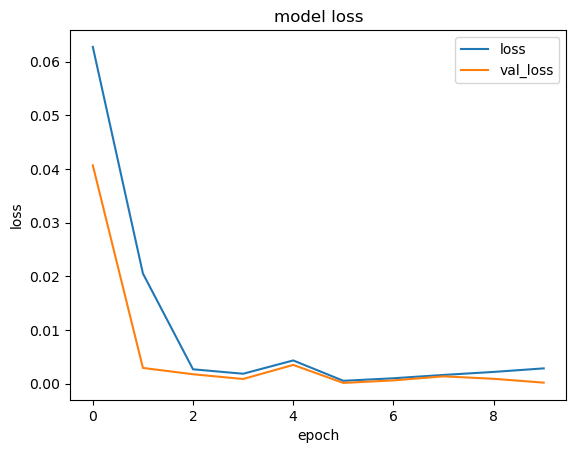

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.show()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.show()


# ARCHITECTURE 2

In [ ]:
import tensorflow as tf

class DualInputCNN(tf.keras.Model):
    def __init__(self):
        super(DualInputCNN, self).__init__()

        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.warping = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same')

        self.conv1a = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',activation='relu')
        self.conv1b = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))

        self.conv2a = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',activation='relu')
        self.conv2b = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))

        self.conv1aa = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), padding='same',activation='relu')
        self.conv1bb = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), padding='same',activation='relu')
        self.pool11 = tf.keras.layers.MaxPooling2D(pool_size=(6, 6))

        self.conv2aa = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same')
        self.conv2bb = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same')
        self.pool22 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))

        self.concat = tf.keras.layers.Concatenate()
        self.concat2 = tf.keras.layers.Concatenate()
        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=16, activation='relu')
        self.dense4 = tf.keras.layers.Dense(units=1, activation='linear')


    def call(self, inputs):
        # Separate inputs
        input1,input2=inputs

        # First input branch
        #x1=self.batchnorm1(input1)
        x1 = self.conv1a(input1)
        x1 = self.conv1b(x1)
        x1 = self.pool1(x1)

        # Second input branch
        #x2=self.batchnorm1(input1)
        x2 = self.conv2a(input2)
        x2 = self.conv2b(x2)
        x2 = self.pool2(x2)


        warp = self.warping(x2)

        x = self.concat([x1, warp])
        x3 = self.conv1aa(x)
        x3 = self.conv1bb(x3)
        x3 = self.pool11(x3)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # Output layers
        y = self.flatten(x3)
        y = self.dense1(y)
        y = self.dense2(y)
        y = self.dense3(y)
        y = self.dense4(y)
        return y



In [ ]:
def bilinear_warp(x, flow):
    _, h, w, _ = tf.unstack(tf.shape(x))
    grid_b, grid_y, grid_x = get_grid(x)
    grid_b = tf.cast(grid_b, tf.float32)
    grid_y = tf.cast(grid_y, tf.float32)
    grid_x = tf.cast(grid_x, tf.float32)

    fx, fy = tf.unstack(flow, axis = -1)
    fx_0 = tf.floor(fx)
    fx_1 = fx_0+1
    fy_0 = tf.floor(fy)
    fy_1 = fy_0+1
    h_lim = tf.cast(h-1, tf.float32)
    w_lim = tf.cast(w-1, tf.float32)
    gy_0 = tf.clip_by_value(grid_y + fy_0, 0., h_lim)
    gy_1 = tf.clip_by_value(grid_y + fy_1, 0., h_lim)
    gx_0 = tf.clip_by_value(grid_x + fx_0, 0., w_lim)
    gx_1 = tf.clip_by_value(grid_x + fx_1, 0., w_lim)

    g_00 = tf.cast(tf.stack([grid_b, gy_0, gx_0], axis = 3), tf.int32)
    g_01 = tf.cast(tf.stack([grid_b, gy_0, gx_1], axis = 3), tf.int32)
    g_10 = tf.cast(tf.stack([grid_b, gy_1, gx_0], axis = 3), tf.int32)
    g_11 = tf.cast(tf.stack([grid_b, gy_1, gx_1], axis = 3), tf.int32)


    x_00 = tf.gather_nd(x, g_00)
    x_01 = tf.gather_nd(x, g_01)
    x_10 = tf.gather_nd(x, g_10)
    x_11 = tf.gather_nd(x, g_11)

    c_00 = tf.expand_dims((fy_1 - fy)*(fx_1 - fx), axis = 3)
    c_01 = tf.expand_dims((fy_1 - fy)*(fx - fx_0), axis = 3)
    c_10 = tf.expand_dims((fy - fy_0)*(fx_1 - fx), axis = 3)
    c_11 = tf.expand_dims((fy - fy_0)*(fx - fx_0), axis = 3)

    return c_00*x_00 + c_01*x_01 + c_10*x_10 + c_11*x_11

In [ ]:
dualInput = DualInputCNN()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
dualInput.compile(optimizer=opt, loss= 'mse', metrics=['accuracy'])
history_3 = dualInput.fit([X_train[:300,:,:],X_train[1:301,:,:]], dxr[1:301], batch_size=5, validation_split=0.3, epochs=5,shuffle=False)

Epoch 1/5
40/40 [==============================] - 1657s 41s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 4.0998e-05 - val_accuracy: 0.4600
Epoch 2/5
40/40 [==============================] - 1668s 42s/step - loss: 4.6835e-06 - accuracy: 1.0000 - val_loss: 3.0495e-05 - val_accuracy: 0.4600
Epoch 3/5
40/40 [==============================] - 1653s 41s/step - loss: 2.7553e-07 - accuracy: 1.0000 - val_loss: 2.8838e-05 - val_accuracy: 0.4600
Epoch 4/5
40/40 [==============================] - 1641s 41s/step - loss: 1.4417e-07 - accuracy: 1.0000 - val_loss: 2.7930e-05 - val_accuracy: 0.4600
Epoch 5/5
40/40 [==============================] - 1638s 41s/step - loss: 7.8562e-08 - accuracy: 1.0000 - val_loss: 2.7330e-05 - val_accuracy: 0.4600


In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.show()

In [ ]:
input1 = Input(shape=(640,480,2), name='input1')
input2 = Input(shape=(640,480,2), name='input2')
output = DualInputCNN()([input1, input2])
dualInput_model = tf.keras.Model(inputs=[input1, input2], outputs=output)


In [ ]:
ifile = 'model_3.jpg'
tf.keras.utils.plot_model (dualInput_model, to_file = ifile, show_shapes = True, show_layer_names = True)

# ARCHITECTURE 3






In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras import layers

class CNN_LSTM_Model(Model):
    def __init__(self):
        super(CNN_LSTM_Model, self).__init__()

        # Define the input layer for the image input
        self.input_image = Input(shape=(height, width, channels))

        # Define the convolutional layers
        self.conv1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')
        self.conv2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')
        self.pool1 = MaxPooling2D(pool_size=(2,2))

        # Define the LSTM layer
        self.lstm = LSTM(64)

        # Define the fully connected layers
        self.flatten_layer = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')

        # Define the output layers
        self.output_layer = Dense(3, activation='linear')

    def call(self, inputs):
        # Define the forward pass through the convolutional layers
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)

        # Flatten and apply LSTM layer
        x = self.flatten_layer(x)
        x = layers.Reshape((-1, 3136))(x) # Adjust the shape to be suitable for the LSTM layer
        x = self.lstm(x)

        # Apply the fully connected layers
        x = self.dense1(x)
        x = self.dense2(x)

        # Apply the output layer
        outputs = self.output_layer(x)

        return outputs


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, concatenate
from tensorflow.keras import layers

class CNN_LSTM_Model2(Model):
    def __init__(self):
        super(CNN_LSTM_Model2, self).__init__()

        # Define the input layer for the first image input
        self.input_image1 = Input(shape=(480, 640, 2))

        # Define the convolutional layers for the first image input
        self.conv1_1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')
        self.conv2_1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')
        self.pool1_1 = MaxPooling2D(pool_size=(2,2))

        # Define the input layer for the second image input
        self.input_image2 = Input(shape=(480, 640, 2))

        # Define the convolutional layers for the second image input
        self.conv1_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')
        self.conv2_2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')
        self.pool1_2 = MaxPooling2D(pool_size=(2,2))

        # Define the LSTM layer
        self.lstm = LSTM(64)

        # Define the fully connected layers
        self.flatten_layer = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')

        # Define the output layers
        self.output_layer = Dense(1, activation='linear')

    def call(self, inputs):
        # Split the inputs into the two images
        image1, image2 = inputs

        # Define the forward pass through the convolutional layers for the first image
        x1 = self.conv1_1(image1)
        x1 = self.conv2_1(x1)
        x1 = self.pool1_1(x1)

        # Define the forward pass through the convolutional layers for the second image
        x2 = self.conv1_2(image2)
        x2 = self.conv2_2(x2)
        x2 = self.pool1_2(x2)

        # Concatenate the outputs of the convolutional layers for both images
        x = concatenate([x1, x2])

        # Flatten and apply LSTM layer
        x = self.flatten_layer(x)
        x = layers.Reshape((-1, 4452))(x) # Adjust the shape to be suitable for the LSTM layer
        x = self.lstm(x)

        # Apply the fully connected layers
        x = self.dense1(x)
        x = self.dense2(x)

        # Apply the output layer
        outputs = self.output_layer(x)

        return outputs


In [ ]:

lstmModel = CNN_LSTM_Model2()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(optimizer=opt, loss=['mean_squared_error'], metrics=['accuracy'])
history_4 = lstmModel.fit([X_train[:300,:,:],X_train[1:301,:,:]], dxr[1:301], batch_size=5, validation_split=0.3, epochs=5,shuffle=False)

# ARCHITECTURES WE HAVEN'T TRIED

# Dual Image CNN

In [ ]:
import tensorflow as tf

class DualImageCNN(tf.keras.Model):
    def __init__(self):
        super(DualImageCNN, self).__init__()

        # Define the layers of the model
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(1, activation='linear')
        self.cost_volume = tf.keras.layers.Lambda(lambda x: self.build_cost_volume(x[0], x[1], 4))

    def call(self, inputs):
        # Define the forward pass of the model
        left_input, right_input = inputs
        x = self.cost_volume([left_input, right_input])
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    def build_cost_volume(self, left_feature_map, right_feature_map, max_disparity):
        # Build the cost volume from the left and right feature maps
        batch_size = tf.shape(left_feature_map)[0]
        height = tf.shape(left_feature_map)[1]
        width = tf.shape(left_feature_map)[2]
        cost_volume = tf.zeros((batch_size, height, width, max_disparity, 2))
        for d in range(max_disparity):
            if d > 0:
                shifted_right_feature_map = tf.roll(right_feature_map, shift=d, axis=2)
            else:
                shifted_right_feature_map = right_feature_map
            cost_volume[:, :, :, d, :] = tf.concat([left_feature_map, shifted_right_feature_map], axis=3)
        return cost_volume


In [ ]:
#print(y_train[0])
dualImage = DualImageCNN()
#model=SingleTaskModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
dualImage.compile(optimizer=opt, loss=['mean_squared_error'], metrics=['accuracy'])
history = dualImage.fit([x_train1,x_train2], vector[232:382], batch_size=20, validation_split=0.3, epochs=10,shuffle=True)